# Accurately predicting human essential genes based on deep learning

This section will present a comparative analysis to demonstrate the application and performance of PyTorch models for addressing sequence-based prediction problems.

We'll try to replicate the [Deep Learning in Genomics Primer Notebook](https://github.com/abidlabs/deep-learning-genomics-primer/blob/master/A_Primer_on_Deep_Learning_in_Genomics_Public.ipynb) which is a supplement to the manuscript [A Primer on Deep Learning in Genomics](https://www.nature.com/articles/s41588-018-0295-5). We've already successfully replicated it before using Machine Learning models and Keras. So, the main focus of this notebook is to also demonstrate the application of ProPythia to the identification of DNA-binding motifs using DNA descriptors, but using a deep learning model this time.

In [1]:
%load_ext autoreload
import pandas as pd
import sys
import os
import torch
from torch import nn
sys.path.append("../")
from descriptors.descriptors import DNADescriptor

In [2]:
dataset = pd.read_csv("datasets/primer/dataset.csv")
print(dataset.shape)
print(dataset.head())

(2000, 2)
                                            sequence  label
0  CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGA...      0
1  GAGTTTATATGGCGCGAGCCTAGTGGTTTTTGTACTTGTTTGTCGC...      0
2  GATCAGTAGGGAAACAAACAGAGGGCCCAGCCACATCTAGCAGGTA...      0
3  GTCCACGACCGAACTCCCACCTTGACCGCAGAGGTACCACCAGAGC...      1
4  GGCGACCGAACTCCAACTAGAACCTGCATAACTGGCCTGGGAGATA...      1


As we can see, this dataset contains the sequence and the corresponding positive/negative class labels, with positive class labels corresponding to the presence of a DNA-binding motif. The amount of positive and negative examples is evenly distributed across the two classes.

<AxesSubplot:xlabel='label'>

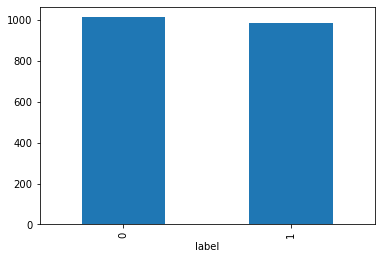

In [3]:
dataset.groupby('label').size().plot(kind='bar')

To calculate features, and to be more easy, we create a function to calculate features, calculating all available DNA features.
There are a total of 17 DNA descriptors. They are: 
- length
- gc_content
- at_content
- nucleic_acid_composition
- dinucleotide_composition
- trinucleotide_composition
- k_spaced_nucleic_acid_pairs
- kmer
- accumulated_nucleotide_frequency
- DAC
- DCC
- DACC
- TAC
- TCC
- TACC
- PseDNC
- PseKNC

In [4]:
def calculate_feature(data):
    list_feature = []
    count = 0
    for seq in data['sequence']:
        res = {'sequence': seq}
        dna = DNADescriptor(seq)
        feature = dna.get_descriptors()
        res.update(feature)
        list_feature.append(res)
        
        # print progress every 100 sequences
        if count % 100 == 0:
            print(count, '/', len(data))

        count += 1
    print("Done!")
    df = pd.DataFrame(list_feature)
    return df

features = calculate_feature(dataset)

0 / 2000
100 / 2000
200 / 2000
300 / 2000
400 / 2000
500 / 2000
600 / 2000
700 / 2000
800 / 2000
900 / 2000
1000 / 2000
1100 / 2000
1200 / 2000
1300 / 2000
1400 / 2000
1500 / 2000
1600 / 2000
1700 / 2000
1800 / 2000
1900 / 2000
Done!


In [5]:
fps_y = dataset['label']
fps_x = features.loc[:, features.columns != 'label']
fps_x = fps_x.loc[:, fps_x.columns != 'sequence']
fps_x.shape

(2000, 17)

Now, we have a dataset (fps_x) with 17 columns. Each column is a result of a DNA descriptor, and some of these columns are numbers, dicts and even lists.

Even though we've computed all of the descriptors, we still need to normalize those who have dictionaries and lists because the model can't handle data in these types.

To normalize the data, dicts and lists need to "explode" into more columns. 

E.g. dicts:

| descriptor_hello |
| ---------------- |
| {'a': 1, 'b': 2} |

will be transformed into:

| descriptor_hello_a | descriptor_hello_b |
| ------------------ | ------------------ |
| 1                  | 2                  |

E.g. lists:

| descriptor_hello |
| ---------------- |
| [1, 2, 3]        |

will be transformed into:

| descriptor_hello_0 | descriptor_hello_1 | descriptor_hello_2 |
| ------------------ | ------------------ | ------------------ |
| 1                  | 2                  | 3                  |

In [6]:
def process_lists(fps_x, field):
    l = fps_x[field].to_list()
    new_df = pd.DataFrame(l)
    new_df.columns = [str(field) + "_" + str(i) for i in new_df.columns]
    fps_x.drop(field, axis=1, inplace=True)
    return new_df

def process_lists_of_lists(fps_x, field):
    l = fps_x[field].to_list()
    new_df = pd.DataFrame(l)
    new_df.columns = [str(field) + "_" + str(i) for i in new_df.columns]
    empty_val = {} if field == "enhanced_nucleic_acid_composition" else []
    small_processed = []
    for f in new_df.columns:
        col = [empty_val if i is None else i for i in new_df[f].to_list()]
        sub = pd.DataFrame(col)
        sub.columns = [str(f) + "_" + str(i) for i in sub.columns]
        small_processed.append(sub)
    fps_x.drop(field, axis=1, inplace=True)
    return small_processed

In [7]:
no_need_normalization = ["length", "at_content", "gc_content"]
lists = ["nucleic_acid_composition","dinucleotide_composition","trinucleotide_composition","k_spaced_nucleic_acid_pairs","kmer","PseDNC", "PseKNC", "DAC", "DCC", "DACC", "TAC","TCC","TACC"]
lists_of_lists = [
    "accumulated_nucleotide_frequency"
]

small_processed = []
for i in lists:
    new_df = process_lists(fps_x, i)
    small_processed.append(new_df)
    
for i in lists_of_lists:
    smaller_processed = process_lists_of_lists(fps_x, i)
    small_processed += smaller_processed

# concat final with original
fps_x = pd.concat([fps_x, *small_processed], axis=1)
fps_x

,length,gc_content,at_content,nucleic_acid_composition_A,nucleic_acid_composition_C,nucleic_acid_composition_G,nucleic_acid_composition_T,dinucleotide_composition_AA,dinucleotide_composition_AC,dinucleotide_composition_AG,...,accumulated_nucleotide_frequency_0_G,accumulated_nucleotide_frequency_0_T,accumulated_nucleotide_frequency_1_A,accumulated_nucleotide_frequency_1_C,accumulated_nucleotide_frequency_1_G,accumulated_nucleotide_frequency_1_T,accumulated_nucleotide_frequency_2_A,accumulated_nucleotide_frequency_2_C,accumulated_nucleotide_frequency_2_G,accumulated_nucleotide_frequency_2_T
0,50,0.60,0.40,0.18,0.26,0.34,0.22,0.041,0.061,0.061,...,0.462,0.154,0.20,0.12,0.40,0.28,0.184,0.184,0.368,0.263
1,50,0.48,0.52,0.12,0.16,0.32,0.40,0.000,0.020,0.061,...,0.308,0.385,0.20,0.16,0.36,0.28,0.158,0.132,0.316,0.395
2,50,0.54,0.46,0.34,0.26,0.28,0.12,0.082,0.061,0.163,...,0.385,0.154,0.44,0.12,0.36,0.08,0.368,0.263,0.263,0.105
3,50,0.64,0.36,0.24,0.42,0.22,0.12,0.020,0.143,0.082,...,0.231,0.077,0.24,0.44,0.16,0.16,0.237,0.421,0.211,0.132
4,50,0.54,0.46,0.28,0.26,0.28,0.18,0.082,0.102,0.041,...,0.308,0.077,0.32,0.36,0.20,0.12,0.289,0.342,0.211,0.158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,50,0.66,0.34,0.16,0.26,0.40,0.18,0.000,0.020,0.082,...,0.538,0.154,0.12,0.20,0.52,0.16,0.184,0.211,0.421,0.184
1996,50,0.44,0.56,0.22,0.22,0.22,0.34,0.041,0.061,0.041,...,0.308,0.308,0.20,0.12,0.28,0.40,0.237,0.211,0.263,0.289
1997,50,0.46,0.54,0.18,0.24,0.22,0.36,0.020,0.061,0.041,...,0.154,0.231,0.16,0.36,0.16,0.32,0.132,0.263,0.211,0.395
1998,50,0.48,0.52,0.28,0.24,0.24,0.24,0.102,0.061,0.041,...,0.462,0.077,0.24,0.32,0.28,0.16,0.237,0.289,0.289,0.184


In [8]:
# save fps_x and fps_y to pickle file
import pickle
with open("datasets/primer/fps_x_descriptor.pkl", "wb") as f:
    pickle.dump(fps_x, f)
with open("datasets/primer/fps_y_descriptor.pkl", "wb") as f:
    pickle.dump(fps_y, f)

In [9]:
%load_ext autoreload
%autoreload 2
from src.hyperparameter_tuning import hyperparameter_tuning
from ray import tune

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
torch.manual_seed(2022)
os.environ["CUDA_VISIBLE_DEVICES"] = '4,5'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class_weights = torch.tensor([1.0, 1.0]).to(device)

fixed_vals = {
    'epochs': 50,
    'optimizer_label': 'adam',
    'loss_function': nn.CrossEntropyLoss(weight=class_weights),
    'patience': 2, 
    'output_size': 2,     
    'model_label': 'mlp',
    'data_dir': 'primer',
    'mode': 'descriptor'
}

# these are hyperparameters to be tuned
config = {
    "hidden_size": tune.choice([32, 64, 128, 256]),
    "lr": tune.loguniform(1e-4, 1e-1),
    "batch_size": tune.choice([8, 16, 32]),
    "dropout": tune.uniform(0.3, 0.5)
}

In [11]:
hyperparameter_tuning(device, fixed_vals, config)

/home/jabreu/miniconda3/envs/dna-conda/lib/python3.8/site-packages/ray/_private/services.py:238: UserWarning: Not all Ray Dashboard dependencies were found. To use the dashboard please install Ray using `pip install ray[default]`. To disable this message, set RAY_DISABLE_IMPORT_WARNING env var to '1'.
  warnings.warn(warning_message)
2022-06-20 18:10:41,744	WARNING experiment.py:295 -- No name detected on trainable. Using DEFAULT.
2022-06-20 18:10:41,746	INFO registry.py:66 -- Detected unknown callable for trainable. Converting to class.


== Status ==
Memory usage on this node: 60.3/754.3 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 32.000: None | Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 2.0/80 CPUs, 2.0/2 GPUs, 0.0/508.97 GiB heap, 0.0/186.26 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jabreu/ray_results/DEFAULT_2022-06-20_18-10-41
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+---------------------+----------+-------+--------------+-----------+---------------+-------------+
| Trial name          | status   | loc   |   batch_size |   dropout |   hidden_size |          lr |
|---------------------+----------+-------+--------------+-----------+---------------+-------------|
| DEFAULT_ea1bc_00000 | RUNNING  |       |           16 |  0.402331 |            32 | 0.0635134   |
| DEFAULT_ea1bc_00001 | PENDING  |       |            8 |  0.499647 |           128 | 0.0621473   |
| DEFAULT_ea1bc_00002 | PENDING  |       |          

2022-06-20 18:12:42,124	INFO tune.py:561 -- Total run time: 120.38 seconds (120.07 seconds for the tuning loop).


== Status ==
Memory usage on this node: 61.7/754.3 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 32.000: None | Iter 16.000: -0.34230102548232444 | Iter 8.000: -0.34085758117529064 | Iter 4.000: -0.3637749493122101 | Iter 2.000: -0.3687023990887862 | Iter 1.000: -0.4081591625855519
Resources requested: 0/80 CPUs, 0/2 GPUs, 0.0/508.97 GiB heap, 0.0/186.26 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jabreu/ray_results/DEFAULT_2022-06-20_18-10-41
Number of trials: 10/10 (10 TERMINATED)
+---------------------+------------+-------+--------------+-----------+---------------+-------------+----------+------------+----------------------+----------+
| Trial name          | status     | loc   |   batch_size |   dropout |   hidden_size |          lr |     loss |   accuracy |   training_iteration |      mcc |
|---------------------+------------+-------+--------------+-----------+---------------+-------------+----------+------------+----------------------+----------|
| DEFA